# BikeSharing Forecasting with RNN and LSTM


### Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.metrics import mean_squared_error

from numpy import array, hstack

from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator

from keras.models import Sequential
from keras.layers import RNN, SimpleRNN, LSTM
from keras.layers import Dense
from keras.optimizers import Adam


## Data Preparation

In [3]:
df = pd.read_csv('data_bikesharing/bike_sharing_dataset_clean_day.csv',
                 index_col='date_time',
                 parse_dates=True)
data = df.copy()
data.head(3)


,holiday,workingday,weather,temp,atemp,hum,windspeed,users,month,weekday
date_time,,,,,,,,,,
2011-01-01,0,0,mist,14.110847,18.18125,80.5833,10.749882,985,1,5
2011-01-02,0,0,mist,14.902598,17.68695,69.6087,16.652113,801,1,6
2011-01-03,0,1,clear,8.050924,9.47025,43.7273,16.636703,1349,1,0


### plot data

In [4]:
def plot_data(data, title, xlabel, ylabel):
    plt.style.use('bmh')
    data.plot(figsize=(12,3))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

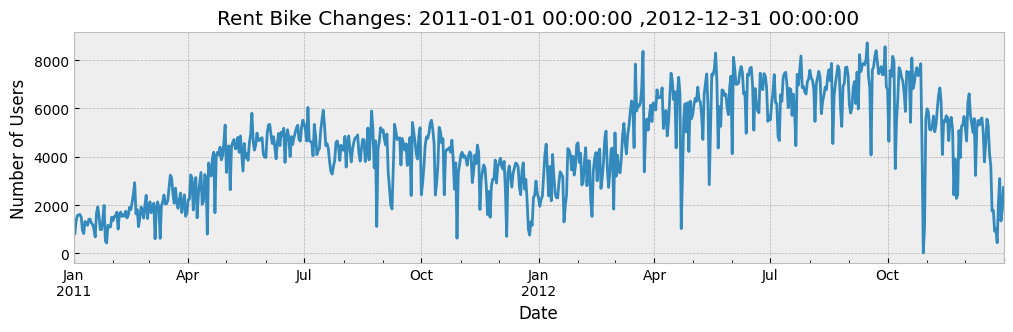

In [5]:
# plot the data
plot_data(data = data['users'],
          title = f'Rent Bike Changes: {data.index.min()} ,{data.index.max()}',
          xlabel = 'Date',
          ylabel = 'Number of Users')

### Data exploration and Manipulation
- Number of bike sharing is 22 only at 2012-10-29 and such a low value deserves a special attention.
- There was a hurricane at Washington at that day.
- Since it is such an extraordinary day, hurricane and the following days data will be replaced by the average of that month.

In [6]:
for i in range(0, 2):
    data['users'].loc[data['users'].idxmin()] = data['users'].mean()

/var/folders/kn/74_zgp_92dq3kqn02k33f_xr0000gn/T/ipykernel_54115/1122382235.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['users'].loc[data['users'].idxmin()] = data['users'].mean()


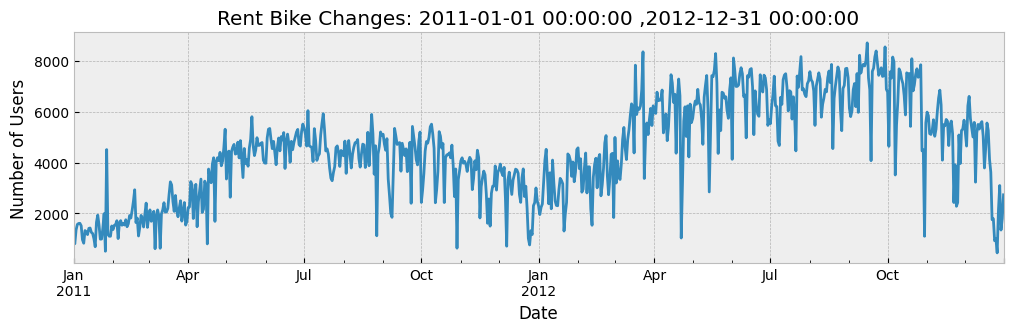

In [7]:
# plot the data
plot_data(data = data['users'],
          title = f'Rent Bike Changes: {data.index.min()} ,{data.index.max()}',
          xlabel = 'Date',
          ylabel = 'Number of Users')

### decomposing the data

The code produces the Observed, Trend, Seasonal, and Residual components:
- Observed: It shows the general pattern of the monthly milk production dataset.
- Trend: It shows the time series uptrend over time.
- Seasonal: It shows the seasonality or the repeating patterns in the time series.
- Residual: It shows the time series after removing the seasonality and trend components.

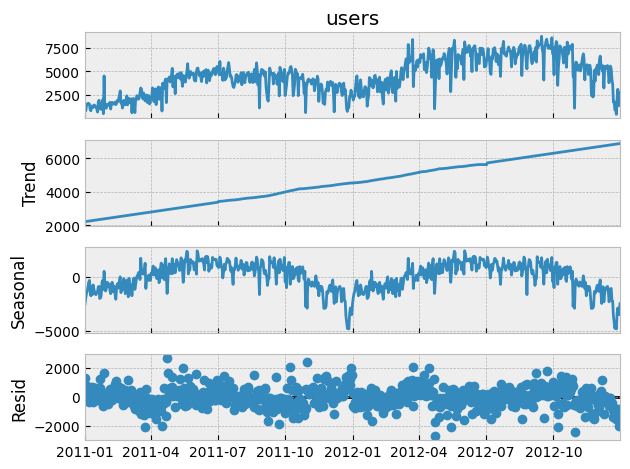

In [8]:
# graphs to show seasonal_decompose

def seasonal_decompose (Y):
    decomposition = sm.tsa.seasonal_decompose(x=Y, model='additive', extrapolate_trend='freq', period=int(len(Y)/2))
    decomposition.plot()
    plt.show()
seasonal_decompose(data['users'])

### one hot encoding

In [9]:
data_onehot = pd.get_dummies(data, columns=['weather', 'weekday','month'])
data_onehot.head(3)


,holiday,workingday,temp,atemp,hum,windspeed,users,weather_clear,weather_mist,weather_rain,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date_time,,,,,,,,,,,,,,,,,,,,,
2011-01-01,0,0,14.110847,18.18125,80.5833,10.749882,985.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2011-01-02,0,0,14.902598,17.68695,69.6087,16.652113,801.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2011-01-03,0,1,8.050924,9.47025,43.7273,16.636703,1349.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### scaling the data

In [10]:
# Scaling the time series dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_users = scaler.fit_transform(array(data_onehot['users']).reshape(len(data_onehot['users']), 1))
series = pd.DataFrame(scaled_users,  index = data_onehot.index, columns=['scaled_users'])
data_scaled = data_onehot.drop(columns=['users'])
data_scaled = pd.merge(data_scaled, series, left_index=True, right_index=True)
data_scaled.head(3)


,holiday,workingday,temp,atemp,hum,windspeed,weather_clear,weather_mist,weather_rain,weekday_0,...,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,scaled_users
date_time,,,,,,,,,,,,,,,,,,,,,
2011-01-01,0,0,14.110847,18.18125,80.5833,10.749882,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.065756
2011-01-02,0,0,14.902598,17.68695,69.6087,16.652113,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.043515
2011-01-03,0,1,8.050924,9.47025,43.7273,16.636703,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0.109755


### splitting the data

In [11]:
# Splitting the time series dataset into train, validation and test dates
end_train = '2012-08-31 23:59:00'
end_validation = '2012-10-31 23:59:00'
data_train = data_scaled.loc[: end_train, :]
data_val = data_scaled.loc[end_train:end_validation, :]
data_test = data_scaled.loc[end_validation:, :]

print(f"Dates total      : {data_scaled.index.min()} --- {data_scaled.index.max()}  (n={len(data_scaled)})")
print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates test       : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates total      : 2011-01-01 00:00:00 --- 2012-12-31 00:00:00  (n=731)
Dates train      : 2011-01-01 00:00:00 --- 2012-08-31 00:00:00  (n=609)
Dates test       : 2012-09-01 00:00:00 --- 2012-10-31 00:00:00  (n=61)
Dates test       : 2012-11-01 00:00:00 --- 2012-12-31 00:00:00  (n=61)


## RNN
- [Time Series Forecasting with RNN](https://www.kaggle.com/code/hozler/time-series-forecasting-with-rnn/notebook)

### Preparing 3-Dimensional Input for Sequential Model¶

In [12]:
in_seq_train, in_seq_val, in_seq_test = [], [], []
for col in data_scaled.columns:
    if 'month' in col:
        continue
    in_seq_train.append(array(data_train[col]).reshape((len(data_train[col]), 1)))
    in_seq_val.append(array(data_val[col]).reshape((len(data_val[col]), 1)))
    in_seq_test.append(array(data_test[col]).reshape((len(data_test[col]), 1)))
    
data_train_feed = hstack(in_seq_train)
data_val_feed = hstack(in_seq_val)
data_test_feed = hstack(in_seq_test)


In [13]:
n_features = data_train_feed.shape[1]
n_input = 14
generator_train = TimeseriesGenerator(data_train_feed, 
                                      array(data_train['scaled_users']).reshape((len(data_train['scaled_users']), 1)), 
                                      length=n_input, 
                                      batch_size=len(data_train_feed))
generator_val = TimeseriesGenerator(data_val_feed, 
                                      array(data_val['scaled_users']).reshape((len(data_val['scaled_users']), 1)), 
                                      length=n_input, 
                                      batch_size=1)
generator_test = TimeseriesGenerator(data_test_feed, 
                                      array(data_test['scaled_users']).reshape((len(data_test['scaled_users']), 1)), 
                                      length=n_input, 
                                      batch_size=1)

### Modelling and Training
- RNN with 4 nodes. 
- Number of total parameters in the model is 93. 
- Number of timesteps in one batch is 14. 
- Activation function is relu both for RNN and Output layer. 
- Optimizer is adam. 
- Loss function is mean squared error. 
- Learning rate is 0.0001. 
- Number of epocs is 3,000.

#### Creating the RNN Model


In [14]:
print(f"timesteps:{n_input}, features:{n_features}")

timesteps:14, features:17


In [15]:
model = Sequential()

model.add(SimpleRNN(4, activation='relu', input_shape=(n_input, n_features), return_sequences = False))
model.add(Dense(1, activation='relu'))

adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 4)                 88        
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 93 (372.00 Byte)
Trainable params: 93 (372.00 Byte)


Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Training the Model


In [16]:
score_rnn = model.fit(generator_train, epochs=1000, verbose=0, validation_data=generator_val)

##### Plot of Train and Valid Loss Functions¶


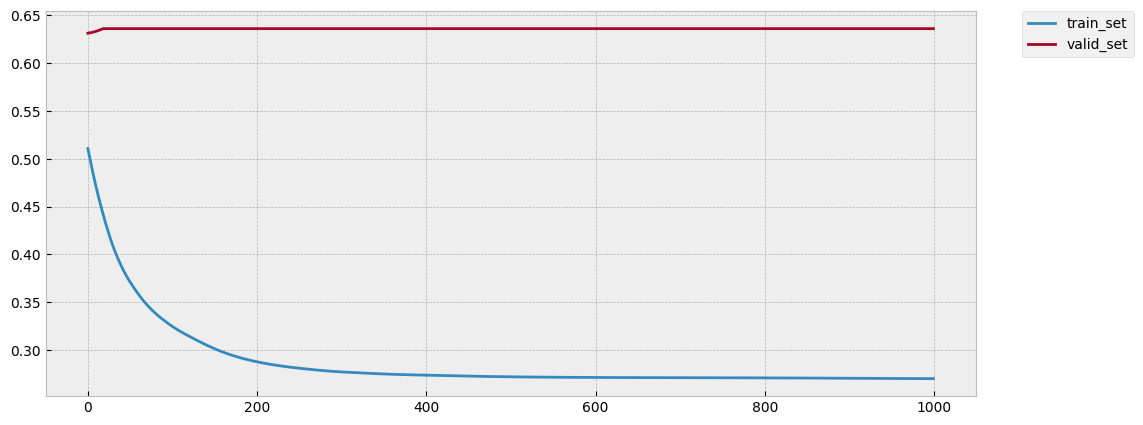

In [17]:
losses = score_rnn.history['loss']
val_losses = score_rnn.history['val_loss']

plt.style.use('bmh')
plt.figure(figsize=(12,5))
plt.plot(losses, label="train_set")
plt.plot(val_losses, label="valid_set")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

#### Predictions for Valid Data¶


##### Predicting for Valid Data

In [18]:
df_result = pd.DataFrame({'Actual_valid' : [], 'Prediction_valid' : []})

for i in range(len(generator_val)):
    x, y = generator_val[i]
    # print(f"input({i})size:{np.shape(x)}\n preditc y shape: {np.shape(y)}")
    x_input = array(x).reshape((1, n_input, n_features))
    yhat = model.predict(x_input, verbose=0)
    new_row = pd.DataFrame({'Actual_valid' : scaler.inverse_transform(y)[0][0], 'Prediction_valid' : scaler.inverse_transform(yhat)[0][0]}, index = [i])
    df_result = pd.concat([df_result, new_row])

##### Tabulating Actuals, Predictions and Differences


In [19]:
df_result['Diff_valid'] = 100 * (df_result['Prediction_valid'] - df_result['Actual_valid']) / df_result['Actual_valid']
df_result.head(3)

,Actual_valid,Prediction_valid,Diff_valid
0,8714.0,441.0,-94.939178
1,7333.0,441.0,-93.986090
2,6869.0,441.0,-93.579852


##### Calculating the Correctness for Valid Data

In [20]:
mean = df_result['Actual_valid'].mean()
mae = (df_result['Actual_valid'] - df_result['Prediction_valid']).abs().mean()

print(f"mean: {mean}")
print(f"mae: {mae}")
print(f"mae/mean ratio:{100*mae/mean}%")
print(f"correctness:{100 - 100*mae/mean}%")

rmse = np.sqrt(mean_squared_error(df_result['Actual_valid'], df_result['Prediction_valid']))
print(f"RMSE: {rmse}")

mean: 6873.432953983176
mae: 6432.432953983176
mae/mean ratio:93.58399211933188%
correctness:6.4160078806681184%
RMSE: 6597.269278370956


##### Plot of Actuals and Predictions for Valid Data

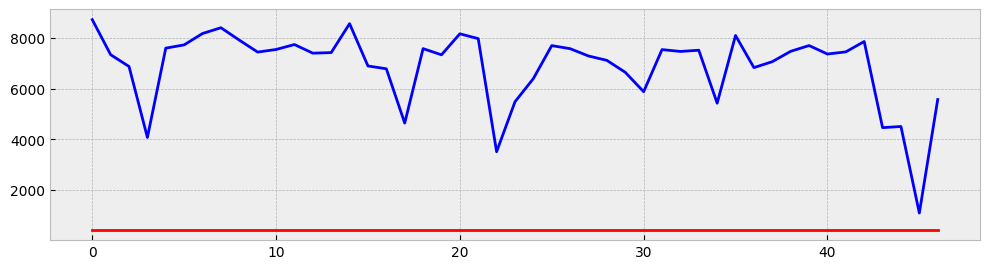

In [21]:
plt.style.use('bmh')
plt.figure(figsize=(12,3))
plt.plot(df_result['Actual_valid'], color='blue')
plt.plot(df_result['Prediction_valid'], color='red')
plt.show()

#### Predictions for Test Data

##### Predicting for Test Data


In [22]:
df_result = pd.DataFrame({'Actual_test' : [], 'Prediction_test' : []})

for i in range(len(generator_test)):
    x, y = generator_test[i]
    x_input = array(x).reshape((1, n_input, n_features))
    yhat = model.predict(x_input, verbose=0)
    new_row = pd.DataFrame({'Actual_test' : scaler.inverse_transform(y)[0][0], 'Prediction_test' : scaler.inverse_transform(yhat)[0][0]}, index = [i])
    df_result = pd.concat([df_result, new_row])

##### Tabulating Actuals, Predictions and Differences for Test Data


In [23]:
df_result['Diff_test'] = 100 * (df_result['Prediction_test'] - df_result['Actual_test']) / df_result['Actual_test']
df_result.head(3)

,Actual_test,Prediction_test,Diff_test
0,5445.0,441.0,-91.900826
1,5698.0,441.0,-92.260442
2,5629.0,441.0,-92.165571


##### Calculating the Correctness for Test Data

In [24]:
mean = df_result['Actual_test'].mean()
mae = (df_result['Actual_test'] - df_result['Prediction_test']).abs().mean()
print(f"mean: {mean}")
print(f"mae: {mae}")
print(f"mae/mean ratio:{100*mae/mean}%")
print(f"correctness:{100 - 100*mae/mean}%")

mse = mean_squared_error(df_result['Actual_test'], df_result['Prediction_test'])
print(f"MSE: {mse}")

rmse = np.sqrt(mean_squared_error(df_result['Actual_test'], df_result['Prediction_test']))
print(f"RMSE: {rmse}")

mean: 4207.787234042553
mae: 3697.6355525889294
mae/mean ratio:87.87601052338607%
correctness:12.123989476613929%
MSE: 16641007.122596024
RMSE: 4079.3390546258865


##### Plot of Actuals and Predictions for Test Data

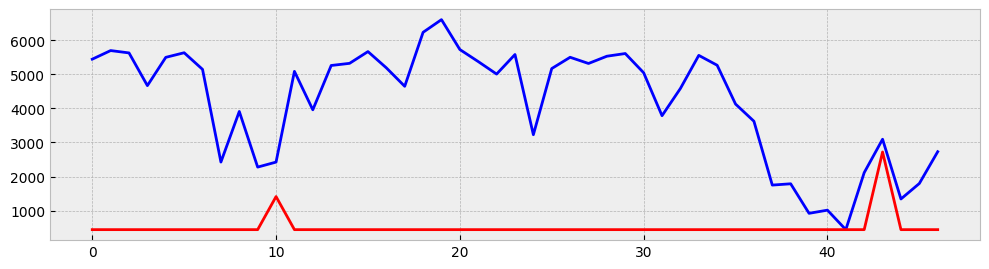

In [25]:
plt.style.use('bmh')
plt.figure(figsize=(12,3))
plt.plot(df_result['Actual_test'], color='blue')
plt.plot(df_result['Prediction_test'], color='red')
plt.show()

### LSTM
- [Univariate Time Series using Recurrent Neural Networks](https://www.section.io/engineering-education/univariate-time-series-using-recurrent-neural-networks/)

#### Modeling


In [40]:
lstm_model = Sequential()
lstm_model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
# adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='mse')
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               47200     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 47301 (184.77 KB)
Trainable params: 47301 (184.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
score_lstm = lstm_model.fit(generator_train, epochs=300, verbose=0, validation_data=generator_val)

#### Plot loss of train and valid

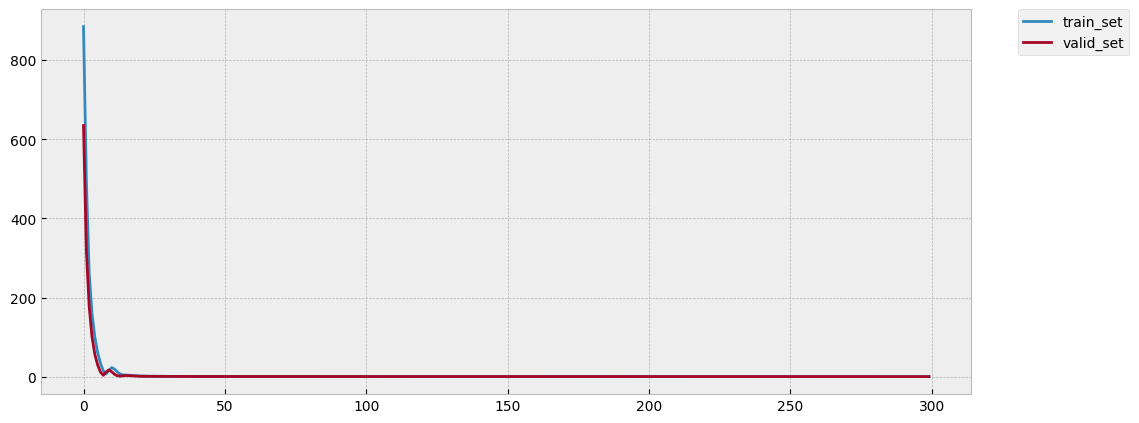

In [42]:
losses = score_lstm.history['loss']
val_losses = score_lstm.history['val_loss']

plt.style.use('bmh')
plt.figure(figsize=(12,5))
plt.plot(losses, label="train_set")
plt.plot(val_losses, label="valid_set")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

#### Prediction for Valid Data

In [43]:
df_result_lstm = pd.DataFrame({'Actual_valid' : [], 'Prediction_valid' : []})

for i in range(len(generator_val)):
    x, y = generator_val[i]
    # print(f"input({i})size:{np.shape(x)}\n preditc y shape: {np.shape(y)}")
    x_input = array(x).reshape((1, n_input, n_features))
    yhat = lstm_model.predict(x_input, verbose=0)
    df_new_row = pd.DataFrame({'Actual_valid' : scaler.inverse_transform(y)[0][0], 'Prediction_valid' : scaler.inverse_transform(yhat)[0][0]},index=[i])
    df_result_lstm = pd.concat([df_result_lstm, df_new_row])

In [44]:
df_result_lstm['Diff_valid'] = 100 * (df_result_lstm['Prediction_valid'] - df_result_lstm['Actual_valid']) / df_result_lstm['Actual_valid']
print(df_result_lstm.head(3))

mean = df_result_lstm['Actual_valid'].mean()
mae = (df_result_lstm['Actual_valid'] - df_result_lstm['Prediction_valid']).abs().mean()

print(f"mean: {mean}")
print(f"mae: {mae}")
print(f"mae/mean ratio:{100*mae/mean}%")
print(f"correctness:{100 - 100*mae/mean}%")

rmse = np.sqrt(mean_squared_error(df_result_lstm['Actual_valid'], df_result_lstm['Prediction_valid']))
print(f"RMSE: {rmse}")

   Actual_valid  Prediction_valid  Diff_valid
0        8714.0       7699.145020  -11.646259
1        7333.0       6653.300293   -9.269054
2        6869.0       8022.539551   16.793413
mean: 6873.432953983176
mae: 2202.711270792422
mae/mean ratio:32.04674120689493%
correctness:67.95325879310508%
RMSE: 2609.1756925689015


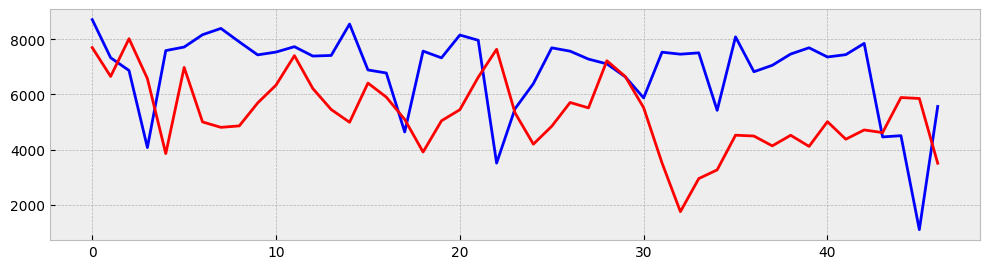

In [45]:
plt.style.use('bmh')
plt.figure(figsize=(12,3))
plt.plot(df_result_lstm['Actual_valid'], color='blue')
plt.plot(df_result_lstm['Prediction_valid'], color='red')
plt.show()

#### Prediction for Test Data

In [46]:
df_result_lstm = pd.DataFrame({'Actual_test' : [], 'Prediction_test' : []})

for i in range(len(generator_test)):
    x, y = generator_test[i]
    # print(f"input({i})size:{np.shape(x)}\n preditc y shape: {np.shape(y)}")
    x_input = array(x).reshape((1, n_input, n_features))
    yhat = lstm_model.predict(x_input, verbose=0)
    df_new_row = pd.DataFrame({'Actual_test' : scaler.inverse_transform(y)[0][0], 'Prediction_test' : scaler.inverse_transform(yhat)[0][0]}, index = [i])
    df_result_lstm = pd.concat([df_result_lstm, df_new_row])

In [47]:
df_result_lstm['Diff_test'] = 100 * (df_result_lstm['Prediction_test'] - df_result_lstm['Actual_test']) / df_result_lstm['Actual_test']
print(df_result_lstm.head(3))

mean = df_result_lstm['Actual_test'].mean()
mae = (df_result_lstm['Actual_test'] - df_result_lstm['Prediction_test']).abs().mean()

print(f"mean: {mean}")
print(f"mae: {mae}")
print(f"mae/mean ratio:{100*mae/mean}%")
print(f"correctness:{100 - 100*mae/mean}%")

rmse = np.sqrt(mean_squared_error(df_result_lstm['Actual_test'], df_result_lstm['Prediction_test']))
print(f"RMSE: {rmse}")

   Actual_test  Prediction_test  Diff_test
0       5445.0      2631.744385 -51.666770
1       5698.0      3003.114990 -47.295279
2       5629.0      4093.464844 -27.279004
mean: 4207.787234042553
mae: 1908.5193858045213
mae/mean ratio:45.356841485802676%
correctness:54.643158514197324%
RMSE: 2136.5866825637486


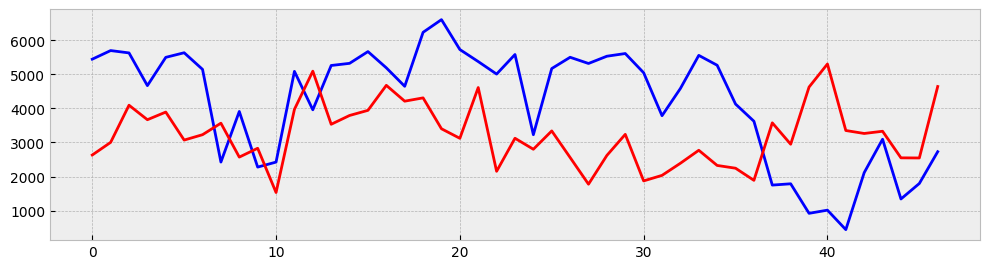

In [48]:
plt.style.use('bmh')
plt.figure(figsize=(12,3))
plt.plot(df_result_lstm['Actual_test'], color='blue')
plt.plot(df_result_lstm['Prediction_test'], color='red')
plt.show()

### LSTM with Hypeparameter Tuning
- [A Comprehensive Guide to LSTM Hyperparameters](https://medium.com/tech-talk-with-chatgpt/a-comprehensive-guide-to-lstm-hyperparameters-3bee384243a)